# Time comparisons beetween normal code and GPU accelarated code for the calculation of a posteriori for a normal likelihood with a fixed variance and a normal prior for the mean

## Data

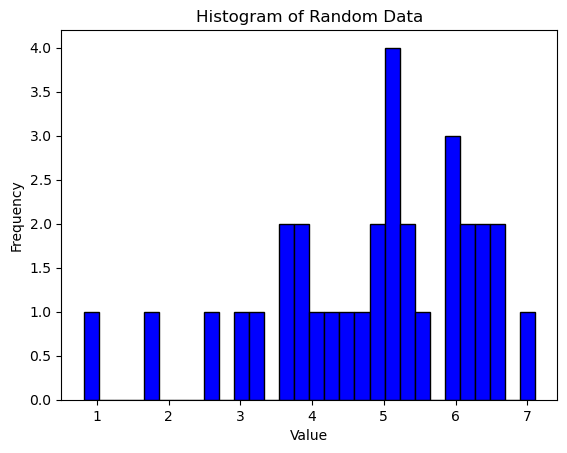

In [2]:
from numba import cuda, float32
import numpy as np
import math
from numba import cuda, float32
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(10)

# data and parameters used in both functions

num_particles = 2048 # Number of particles
sigma = np.float64(2.0)    # Known standard deviation of the data

# Initialize particles and weights
prior_mu = np.float64(0.0); prior_sigma = np.float64(3.0)   # Prior mean and standard deviation
particles = np.random.normal(prior_mu, prior_sigma, num_particles).astype(np.float64)  # Sample from the prior distribution

# Generate synthetic data
true_mu = np.float64(5.0); sigma = np.float64(2.0)    # Known mean and standard deviation of the data
n_data = 32     # Number of data points
data = np.array(np.random.normal(true_mu, sigma, n_data),dtype=np.float64)

###################
# CUDA parameters #
threads = 246
blocks = 8
# -----------
# CUDA arrays
d_data = cuda.to_device(np.array(data,dtype=np.float64))
d_particles = cuda.to_device(np.array(particles ,dtype = np.float64))
d_out = cuda.device_array_like(d_particles)
# -----------
###################

# Create a histogram
plt.hist(data, bins=30, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Random Data')

# Show the plot
plt.show()

## Cuda numba code (posterior calc) errado

In [1]:
from numba import cuda, float32
import numpy as np
import math
from numba import cuda, float32
np.random.seed(10)

# Leave the values in this cell fixed for this exercise
n = 1024
prior_mu = (np.random.normal(0, 3,n)).astype(np.float32)
data = (np.random.normal(5, 2,n)).astype(np.float32)

d_mu = cuda.to_device(np.array(prior_mu,dtype=np.float32))
d_data = cuda.to_device(np.array(data,dtype=np.float32))
d_out = cuda.device_array_like(d_mu)

In [2]:
@cuda.jit
def posterior_calc(prior_mu,data,out):
    start = cuda.grid(1)
    stride = cuda.gridsize(1)

    likelihood = cuda.shared.array(shape=(1,),dtype = float32)
    prior_d_mu = cuda.shared.array(shape=(1,),dtype = float32)
    sum_part = cuda.shared.array(shape=(n,),dtype = float32)
    
    value = cuda.shared.array(shape=(1,),dtype = float32)

    for i in range(start,data.shape[0],stride):
        value = (data[i]-prior_mu[start])**2
        cuda.atomic.add(sum_part, start, value)
    
    # prior distributions
    prior_d_mu[0] = ( 1/(math.sqrt(2*math.pi*(3))) )*math.exp( -(prior_mu[start]-0)/2*3 )

    # likelihood fucntion
    likelihood[0] = ((1/math.sqrt(2*math.pi*(2)))**data.shape[0])*math.exp((1/(2*(2))) * sum_part[start]) 

    out[start] = likelihood[0] * prior_d_mu[0]


In [3]:
np.random.seed(10)
threads = 128
blocks = 8

%timeit -n 1 -r 100 posterior_calc[blocks, threads](d_mu,d_data,d_out) ; cuda.synchronize()

/home/erick/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 8 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


The slowest run took 8573.10 times longer than the fastest. This could mean that an intermediate result is being cached.
8.42 ms ± 82.1 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)


In [6]:
d_out.copy_to_host()
print(n)

1024


## Normal code (posterior calc) errado

In [18]:
np.random.seed(10)
from numba import cuda, float32
import numpy as np
import math
from numba import cuda, float32
np.random.seed(10)

# Leave the values in this cell fixed for this exercise
n = 1024
prior_mu = (np.random.normal(0, 3,n)).astype(np.float32)
data = (np.random.normal(5, 2,n)).astype(np.float32)

In [19]:
np.random.seed(10)
def posterior_calc(prior_mu,data):

    out = np.zeros(data.shape[0])
    for prior in range(0,data.shape[0]):
        sum_part = 0 
        for i in range(0,data.shape[0]):
            value = (data[i]-prior_mu[prior])**2
            sum_part += value
    
        # prior distributions
        prior_d_mu = np.float64( ( 1/(np.sqrt(2*math.pi*(3))) )*np.exp( -(prior_mu[prior]-0)/2*3 ) ) 
    
        # likelihood fucntion
        likelihood = np.float64( ((1/np.sqrt(2*np.pi*(2)))**data.shape[0]) * np.exp((1/(2*(2))) * sum_part) )
    
        out[prior] = likelihood * prior_d_mu 

    return out

In [23]:
np.random.seed(10)
%timeit -n 1 -r 100  values = posterior_calc(prior_mu,data)

/tmp/ipykernel_2465/2806725920.py:15: RuntimeWarning: overflow encountered in exp
  likelihood = np.float64( ((1/np.sqrt(2*np.pi*(2)))**data.shape[0]) * np.exp((1/(2*(2))) * sum_part) )
/tmp/ipykernel_2465/2806725920.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  likelihood = np.float64( ((1/np.sqrt(2*np.pi*(2)))**data.shape[0]) * np.exp((1/(2*(2))) * sum_part) )


2.55 s ± 335 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)


# Time comparisons beetween normal code and GPU accelarated code for the calculation of a likelihood for a normal likelihood with a fixed variance and a normal prior for the mean

## Data

In [4]:
from numba import cuda, float32
import numpy as np
import math
from numba import cuda, float32
np.random.seed(10)

# data and parameters used in both functions
num_particles = 10240   # Number of particles
sigma = np.float32(2.0)    # Known standard deviation of the data

# Initialize particles and weights
prior_mu = np.float32(0.0); prior_sigma = np.float32(3.0)   # Prior mean and standard deviation
particles = np.random.normal(prior_mu, prior_sigma, num_particles).astype(np.float32)  # Sample from the prior distribution

# Generate synthetic data
true_mu = np.float32(5.0); sigma = np.float32(2.0)    # Known mean and standard deviation of the data
n_data = 32       # Number of data points
data = np.array(np.random.normal(true_mu, sigma, n_data),dtype=np.float32)

###################
# CUDA parameters #
threads = 256
blocks = 40
# -----------
# CUDA arrays
d_data = cuda.to_device(np.array(data,dtype=np.float32))
d_particles = cuda.to_device(np.array(particles ,dtype = np.float32))
d_out = cuda.device_array_like(d_particles)
# -----------
###################

## Cuda numba code (likelihood calc)

In [5]:
from numba import cuda, float32

@cuda.jit
def likelihood_calc(prior_sigma,prior_mu,sigma,mu,data,out):
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    
    #likelihood = cuda.shared.array(shape=(1,),dtype = np.float64)
    sum_part = cuda.shared.array(shape=(num_particles,),dtype = np.float32)
    
    value = cuda.shared.array(shape=(1,),dtype = np.float32)

    for i in range(0,data.shape[0]):
        value[0] = ((data[i]-mu[start])/sigma)**2
        cuda.atomic.add(sum_part, start, value[0])
        
    # likelihood fucntion 
    out[start] = ((1/(sigma*math.sqrt(2*math.pi)))**data.shape[0]) * math.exp(-0.5*sum_part[start])

In [7]:
%timeit -n 1 -r 1000 likelihood_calc[blocks, threads](prior_sigma, prior_mu, sigma, d_particles,d_data,d_out)

The slowest run took 220.06 times longer than the fastest. This could mean that an intermediate result is being cached.
159 μs ± 810 μs per loop (mean ± std. dev. of 1000 runs, 1 loop each)


## Normal code (likelihood calc)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
np.random.seed(10)

# Define the likelihood function (normal distribution)
def likelihood(y, mu, sigma):
    return np.prod(np.exp(-0.5 * ((y - mu) / sigma)**2) / (sigma * np.sqrt(2 * np.pi)))

def main(data,particles,sigma):
    likelihood_v = np.array([likelihood(data, theta, sigma) for theta in particles])
    return(likelihood_v)

In [9]:
%timeit -n 1 -r 1000 main(data,particles,sigma)

175 ms ± 57.5 ms per loop (mean ± std. dev. of 1000 runs, 1 loop each)


In [6]:
x_values = np.array([1024,2048,4096,8192,10240])

gpu_mean = np.array([0.140,0.112,0.137,0.091,0.159])
gpu_std = np.array([0.675,0.261,0.660,0.409,0.810])

normal_mean = np.array([15.1,32,65.8,127,175])
normal_std = np.array([4.6,9.91,18.4,32.9,57.5])

## graphs

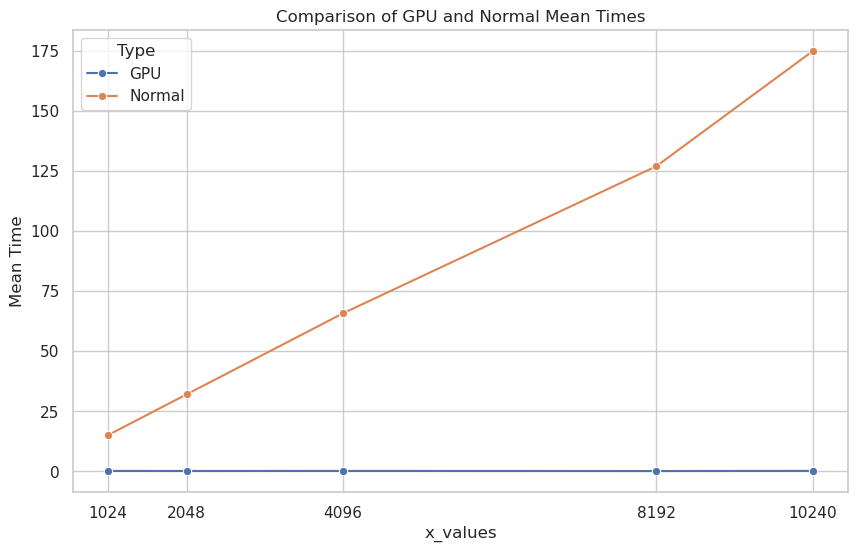

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data
x_values = np.array([1024, 2048, 4096, 8192, 10240])
gpu_mean = np.array([0.140, 0.112, 0.137, 0.091, 0.159])
normal_mean = np.array([15.1, 32, 65.8, 127, 175])

# Create a DataFrame for Seaborn
data = pd.DataFrame({
    'x_values': np.concatenate([x_values, x_values]),
    'Mean': np.concatenate([gpu_mean, normal_mean]),
    'Type': ['GPU'] * len(x_values) + ['Normal'] * len(x_values)
})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='x_values', y='Mean', hue='Type', data=data, marker='o')

# Add labels and title
plt.xlabel('x_values')
plt.ylabel('Mean Time')
plt.title('Comparison of GPU and Normal Mean Times')
plt.xticks(x_values)  # Set x-axis ticks to x_values
plt.grid(True)

# Show the plot
plt.show()

In [17]:
  # Range of x values

array([0.00000000e+00, 2.00020002e-02, 4.00040004e-02, ...,
       1.99959996e+02, 1.99979998e+02, 2.00000000e+02])

# (2) Time comparisons beetween normal code and GPU accelarated code for the calculation of a posteriori for a normal likelihood with a fixed variance and a normal prior for the mean with the Metropolis-Hastings algorithm

## Normal code

<>:76: SyntaxWarning: invalid escape sequence '\m'
<>:76: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_4282/3445902902.py:76: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mu$')


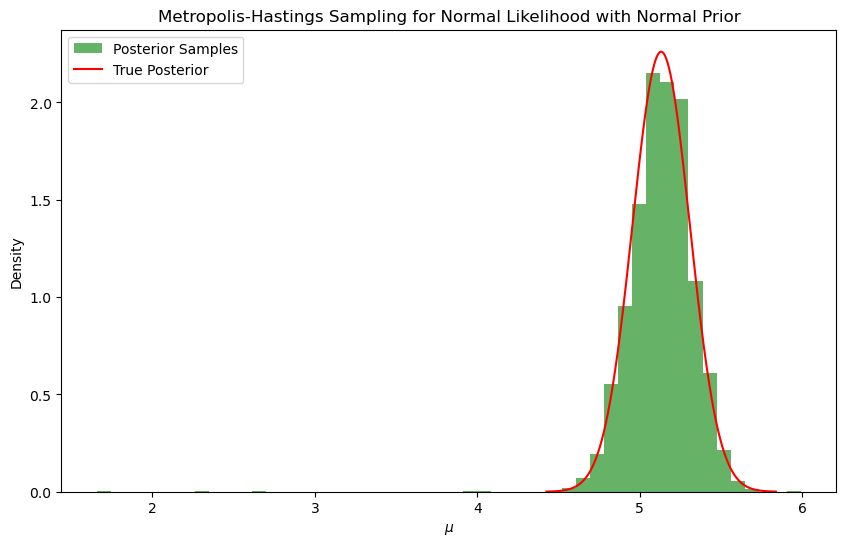

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Define the likelihood function (normal distribution)
def likelihood(y, mu, sigma):
    return np.prod(np.exp(-0.5 * ((y - mu) / sigma)**2) / (sigma * np.sqrt(2 * np.pi)))

# Define the prior function (normal distribution)
def prior(mu, mu_0, tau_0):
    return np.exp(-0.5 * ((mu - mu_0) / tau_0)**2) / (tau_0 * np.sqrt(2 * np.pi))

# Define the posterior function (up to a normalizing constant)
def posterior(y, mu, sigma, mu_0, tau_0):
    return likelihood(y, mu, sigma) * prior(mu, mu_0, tau_0)

# Metropolis-Hastings algorithm
def metropolis_hastings(y, sigma, mu_0, tau_0, n_samples, initial_state, proposal_std):
    samples = []
    current_state = initial_state
    
    for _ in range(n_samples):
        # Propose a new state from a symmetric normal distribution
        proposed_state = np.random.normal(current_state, proposal_std)
        
        # Compute acceptance probability
        acceptance_ratio = posterior(y, proposed_state, sigma, mu_0, tau_0) / posterior(y, current_state, sigma, mu_0, tau_0)
        acceptance_prob = min(1, acceptance_ratio)
        
        # Accept or reject the proposal
        if np.random.rand() < acceptance_prob:
            current_state = proposed_state
        
        # Save the current state
        samples.append(current_state)
    
    return np.array(samples)

# Generate synthetic data
np.random.seed(10)
true_mu = 5.0  # True mean
sigma = 2.0    # Known standard deviation of the data
n = 128      # Number of data points
y = np.random.normal(true_mu, sigma, n)

# Prior parameters
mu_0 = 0.0     # Prior mean
tau_0 = 3.0    # Prior standard deviation

# Metropolis-Hastings parameters
n_samples = 10000     # Number of samples to generate
initial_state = 0.0    # Initial state
proposal_std = 1.0     # Standard deviation of the proposal distribution

# Run the algorithm
samples = metropolis_hastings(y, sigma, mu_0, tau_0, n_samples, initial_state, proposal_std)

# Plot the results
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', label='Posterior Samples')

# Plot the true posterior (for comparison)
# The true posterior is a normal distribution:
# p(mu | y) ~ N(mu_n, tau_n^2), where:
# mu_n = (mu_0 / tau_0^2 + n * y_bar / sigma^2) / (1 / tau_0^2 + n / sigma^2)
# tau_n^2 = 1 / (1 / tau_0^2 + n / sigma^2)
y_bar = np.mean(y)
mu_n = (mu_0 / tau_0**2 + n * y_bar / sigma**2) / (1 / tau_0**2 + n / sigma**2)
tau_n = np.sqrt(1 / (1 / tau_0**2 + n / sigma**2))

# Plot the true posterior
x_values = np.linspace(mu_n - 4 * tau_n, mu_n + 4 * tau_n, 1000)
true_posterior = np.exp(-0.5 * ((x_values - mu_n) / tau_n)**2) / (tau_n * np.sqrt(2 * np.pi))
plt.plot(x_values, true_posterior, 'r-', label='True Posterior')

plt.title('Metropolis-Hastings Sampling for Normal Likelihood with Normal Prior')
plt.xlabel('$\mu$')
plt.ylabel('Density')
plt.legend()
plt.show()

In [47]:
# Run the algorithm
%timeit -n 1 -r 100 metropolis_hastings(y, sigma, mu_0, tau_0, n_samples, initial_state, proposal_std)

337 ms ± 58.1 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)


# (3) Time comparisons beetween normal code and GPU accelarated code for the calculation of a posteriori for a normal likelihood with a fixed variance and a normal prior for the mean with the Sequential Monte Carlo (SMC), also known as particle filtering algorithm

## Data

In [1]:
from numba import cuda, float32
import numpy as np
import math
from numba import cuda, float32, float64
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(10)
# SMC parameters
num_particles = 10240 #1024  # Number of particles
num_iterations = 10  # Number of intermediate distributions
resampling_threshold = 0.5 # Resampling threshold (effective sample size fraction)

# Generate synthetic data
true_mu = np.float32(5.0); sigma = np.float32(2.0)    # Known mean and standard deviation of the data
n_data = 32      # Number of data points
data = np.array(np.random.normal(true_mu, sigma, n_data),dtype=np.float32)

## Cuda code

/home/erick/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 40 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_16237/1702141879.py:45: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.array(np.log(d_out.copy_to_host()))
/tmp/ipykernel_16237/1702141879.py:47: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights) + gamma * log_likelihood


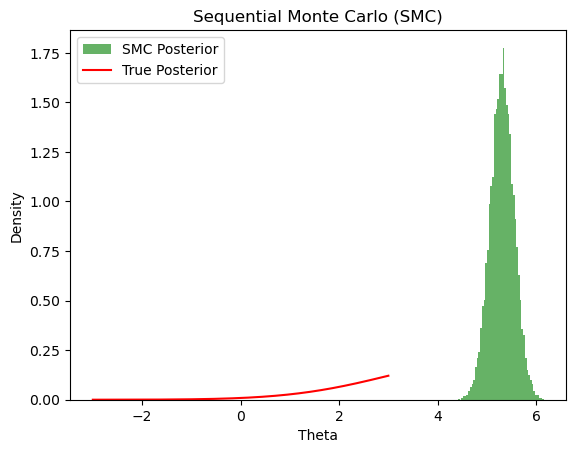

In [11]:
@cuda.jit
def likelihood_calc(prior_sigma,prior_mu,sigma,mu,data,out):
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    
    #likelihood = cuda.shared.array(shape=(1,),dtype = np.float64)
    sum_part = cuda.shared.array(shape=(num_particles,),dtype = np.float32)
    
    value = cuda.shared.array(shape=(1,),dtype = np.float32)

    for i in range(0,data.shape[0]):
        value[0] = ((data[i]-mu[start])/sigma)**2
        cuda.atomic.add(sum_part, start, value[0])
        
    # likelihood fucntion 
    out[start] = ((1/(sigma*math.sqrt(2*math.pi)))**data.shape[0]) * math.exp(-0.5*sum_part[start])
    
# Metropolis-Hastings algorithm
def particle_filtering(num_iterations,num_particles,resampling_threshold,data):

    sigma = np.float32(2.0)    # Known standard deviation of the data
    # Initialize particles and weights
    prior_mu = np.float32(0.0); prior_sigma = np.float32(3.0)   # Prior mean and standard deviation
    particles = np.random.normal(prior_mu, prior_sigma, num_particles).astype(np.float32)  # Sample from the prior distribution
    weights = np.ones(num_particles) / num_particles  # Initial weights

    # CUDA arrays
    d_data = cuda.to_device(np.array(data,dtype=np.float32))
    # -----------
    # Compute annealing temperature
    for t in range(1,num_iterations+1):
        
        # CUDA arrays
        d_particles = cuda.to_device(np.array(particles ,dtype = np.float32))
        d_out = cuda.device_array_like(d_particles)
        # -----------
        gamma =  t/ num_iterations  # Linearly increasing temperature
    
        # ---- Cuda function initializaion parametes ----- # 
        threads = 256 
        blocks = 40
        # ------------------------------------------------ #
        # Update weights
        likelihood_calc[blocks, threads](prior_sigma, prior_mu, sigma, d_particles,d_data,d_out)
        log_likelihood = np.array(np.log(d_out.copy_to_host()))
        
        log_weights = np.log(weights) + gamma * log_likelihood
        log_weights -= np.max(log_weights)  # Normalize for numerical stability
        weights = np.exp(log_weights)
        weights /= np.sum(weights)  # Normalize weights

        # Effective sample size (ESS)
        ess = 1 / np.sum(weights**2)
        
        # Resampling step (if ESS is too low)
        if ess < resampling_threshold * num_particles:
            indices = np.random.choice(num_particles, size=num_particles, p=weights)    
            particles = particles[indices]
            weights = np.ones(num_particles) / num_particles  # Reset weights
            
        # Propagation step (optional: add noise to particles)
        particles += np.random.normal(0, 0.1, num_particles)  # Small random walk
        
    return particles, weights

 
# Run the algorithm 
# Final posterior approximation
posterior_samples = particle_filtering(num_iterations, num_particles, resampling_threshold, data)

# Plot the results
plt.hist(posterior_samples[0], bins=50, density=True, alpha=0.6, color='g', label='SMC Posterior')
x = np.linspace(-3, 3, 1000)
plt.plot(x, norm.pdf(x, loc=true_mu, scale=sigma), 'r-', label='True Posterior')
plt.title("Sequential Monte Carlo (SMC)")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

In [3]:
%timeit -n 1 -r 100 particle_filtering(num_iterations, num_particles, resampling_threshold, data)

/tmp/ipykernel_16237/2357137735.py:45: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.array(np.log(d_out.copy_to_host()))
/tmp/ipykernel_16237/2357137735.py:47: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights) + gamma * log_likelihood


27.7 ms ± 5.46 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)


## Normal code

/tmp/ipykernel_16237/1274791765.py:23: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.array([np.log(likelihood(data, theta, sigma)) for theta in particles])
/tmp/ipykernel_16237/1274791765.py:24: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights) + gamma * log_likelihood


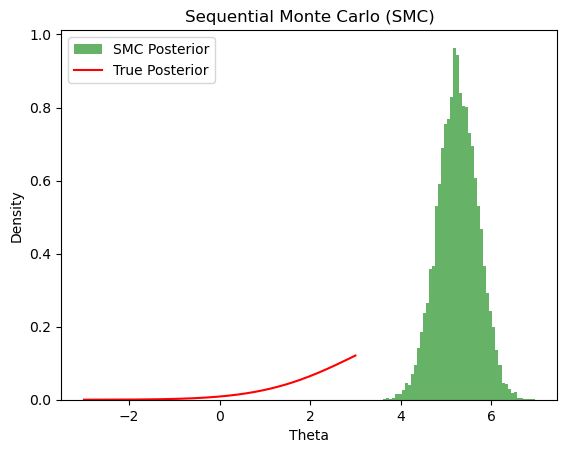

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the likelihood function (normal distribution)
def likelihood(y, mu, sigma):
    return np.prod(np.exp(-0.5 * ((y - mu) / sigma)**2) / (sigma * np.sqrt(2 * np.pi)))

def main(data,num_particles,resampling_threshold,sigma):
    # Initialize particles and weights
    prior_mu = np.float32(0.0); prior_sigma = np.float32(3.0)   # Prior mean and standard deviation
    particles = np.random.normal(prior_mu, prior_sigma, num_particles)  # Sample from the prior
    weights = np.ones(num_particles) / num_particles  # Initial weights
    
    # Update weights
    
    # SMC algorithm
    for t in range(1, num_iterations + 1):
        # Compute annealing temperature
        gamma = t / num_iterations  # Linearly increasing temperature
        
        # Update weights
        log_likelihood = np.array([np.log(likelihood(data, theta, sigma)) for theta in particles])
        log_weights = np.log(weights) + gamma * log_likelihood
        log_weights -= np.max(log_weights)  # Normalize for numerical stability
        weights = np.exp(log_weights)
        weights /= np.sum(weights)  # Normalize weights
        
        # Effective sample size (ESS)
        ess = 1 / np.sum(weights**2)
        
        # Resampling step (if ESS is too low)
        if ess < resampling_threshold * num_particles:
            indices = np.random.choice(num_particles, size=num_particles, p=weights)
            particles = particles[indices]
            weights = np.ones(num_particles) / num_particles  # Reset weights
    
        # Propagation step (optional: add noise to particles)
        particles += np.random.normal(0, 0.1, num_particles)  # Small random walk
    
    # Final posterior approximation
    posterior_samples = particles
    return posterior_samples, weights

posterior_samples = main(data,num_particles,resampling_threshold,sigma)

# Plot the results
plt.hist(posterior_samples[0], bins=50, density=True, alpha=0.6, color='g', label='SMC Posterior')
x = np.linspace(-3, 3, 1000)
plt.plot(x, norm.pdf(x, loc=true_mu, scale=sigma), 'r-', label='True Posterior')
plt.title("Sequential Monte Carlo (SMC)")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

In [5]:
%timeit -n 1 -r 100 main(num_iterations, num_particles, resampling_threshold, data)

/tmp/ipykernel_16237/1274791765.py:23: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.array([np.log(likelihood(data, theta, sigma)) for theta in particles])
/tmp/ipykernel_16237/1274791765.py:24: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights) + gamma * log_likelihood


1.42 s ± 64.5 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)


In [ ]:
x_values = np.array([1024,2048,4096,8192,10240])

gpu_mean = np.array([15,15.3,15.9,21.3,27.7])
gpu_std = np.array([4.12,6.11,4.89,3.56,5.46])

normal_mean = np.array([158,329,614,1130,1420])
normal_std = np.array([31,68.6,125,106,64.5])

# (4) Time comparisons beetween normal code and GPU accelarated code for the calculation of a posteriori for a double normal likelihood.

## Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numba import cuda, float32, float64
import math
from scipy.stats import invgamma
import pandas as pd

np.random.seed(10)
# SMC parameters
num_particles = 8192 #1024  # Number of particles
num_iterations = 200  # Number of intermediate distributions
resampling_threshold = 0.5 # Resampling threshold (effective sample size fraction)

# Parameters for the two normal distributions
mu1, sigma1 = 0, 1  # Mean and standard deviation of the first normal distribution
mu2, sigma2 = 5, 2  # Mean and standard deviation of the second normal distribution
w = 0.6  # Weight of the first normal distribution

# Number of samples to generate
n_samples = 128

# Step 1: Randomly choose which distribution to sample from
choices = np.random.choice([0, 1], size=n_samples, p=[w, 1 - w])

# Step 2: Sample from the chosen distribution
data = np.zeros(n_samples)
for i in range(n_samples):
    if choices[i] == 0:
        data[i] = np.random.normal(mu1, sigma1)  # Sample from the first distribution
    else:
        data[i] = np.random.normal(mu2, sigma2)  # Sample from the second distribution

data = data.astype(np.float32)

###################

##############################################################################################################
# ---------------------------------------------------------------------------------------------------------- #
##############################################################################################################

"""
# Plot the histogram of the samples
plt.hist(samples, bins=50, density=True, alpha=0.6, color='blue', edgecolor='black')

# Overlay the theoretical PDF of the double normal distribution
x = np.linspace(-10, 15, 1000)
f1 = norm.pdf(x, mu1, sigma1)
f2 = norm.pdf(x, mu2, sigma2)
f = w * f1 + (1 - w) * f2  # Combined PDF
plt.plot(x, f, label='Double Normal PDF', color='red')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Sampling from a Double Normal Distribution')
plt.legend()

# Show the plot
plt.show()

"""

"\n# Plot the histogram of the samples\nplt.hist(samples, bins=50, density=True, alpha=0.6, color='blue', edgecolor='black')\n\n# Overlay the theoretical PDF of the double normal distribution\nx = np.linspace(-10, 15, 1000)\nf1 = norm.pdf(x, mu1, sigma1)\nf2 = norm.pdf(x, mu2, sigma2)\nf = w * f1 + (1 - w) * f2  # Combined PDF\nplt.plot(x, f, label='Double Normal PDF', color='red')\n\n# Add labels and legend\nplt.xlabel('x')\nplt.ylabel('Density')\nplt.title('Sampling from a Double Normal Distribution')\nplt.legend()\n\n# Show the plot\nplt.show()\n\n"

## Normal code

In [4]:
import numpy as np
from scipy.stats import norm
from scipy.stats import invgamma

def double_normal_log_likelihood_1(X, mu1, sigma1, mu2, sigma2, w):
    """
    Compute the log-likelihood of a double normal distribution.

    Parameters:
        X (array-like): The observed data.
        mu1, sigma1 (float): Parameters of the first normal distribution.
        mu2, sigma2 (float): Parameters of the second normal distribution.
        w (float): Weight of the first normal distribution (0 <= w <= 1).

    Returns:
        float: The log-likelihood value.
    """
    # Compute the PDFs of the two normal distributions
    f1 = np.exp(-0.5 * ((X - mu1) / sigma1)**2) / (sigma1 * np.sqrt(2 * np.pi))
    f2 = np.exp(-0.5 * ((X - mu2) / sigma2)**2) / (sigma2 * np.sqrt(2 * np.pi))

    # Compute the mixture PDF
    mixture_pdf = w * f1 + (1 - w) * f2

    # Compute the log-likelihood
    log_likelihood = np.sum(np.log(mixture_pdf)).astype(np.float32)

    return log_likelihood

from numba import cuda, float32


def main(data,num_particles,resampling_threshold,mu1,sigma1,mu2,sigma2,w):

    #############################
    # priors for the parameters #
    # mu1 
    prior_mean1 = np.float32(0.0); prior_std1 = np.float32(3.0)  # prior mean and sigma for the mu1 as a normal distribuion
    particles_mu1 = np.random.normal(prior_mean1, prior_std1, num_particles)  # Sample from the prior

    # simga1 
    alpha = np.float32(3.0) ; beta =  np.float32(2.0) # Shape parameter and Scale parameter
    particles_sigma1 = invgamma.rvs(a=alpha, scale=beta, size=num_particles)  # Sample from the prior

    # mu1 
    prior_mean2 = np.float32(1.0); prior_std2 = np.float32(3.0)  # prior mean and sigma for the mu1 as a normal distribuion
    particles_mu2 = np.random.normal(prior_mean2, prior_std2, num_particles)  # Sample from the prior

    # simga1 
    alpha2 = np.float32(3.0) ; beta2 = np.float32(2.0) # Shape parameter and Scale parameter
    particles_sigma2 = invgamma.rvs(a=alpha2, scale=beta2, size=num_particles)  # Sample from the prior

    # w 
    particles_w = np.random.uniform(0, 1, num_particles)
    
    #############################
    
    # Initialize particles and weights   
    weights = np.ones(num_particles) / num_particles  # Initial weights
    
    # Update weights

    # SMC algorithm
    for t in range(1, num_iterations + 1):
        # Compute annealing temperature
        gamma = t / num_iterations  # Linearly increasing temperature
        
        # Update weights
        log_likelihood = np.array([(double_normal_log_likelihood_1(data, particles_mu1[i],particles_sigma1[i],particles_mu2[i],particles_sigma2[i],particles_w[i])) for i in range(0,num_particles)])
        log_weights = np.log(weights) + gamma * log_likelihood
        log_weights -= np.max(log_weights)  # Normalize for numerical stability
        weights = np.exp(log_weights)
        weights /= np.sum(weights)  # Normalize weights

        print(weights)
        
        # Effective sample size (ESS)
        ess = 1 / np.sum(weights**2)
        
        # Resampling step (if ESS is too low)
        if ess < resampling_threshold * num_particles:
            indices = np.random.choice(num_particles, size=num_particles, p=weights)
            particles_mu1 = particles_mu1[indices]
            particles_sigma1 = particles_sigma1[indices]
            particles_mu2 = particles_mu2[indices]
            particles_sigma2 = particles_sigma2[indices]
            particles_w = particles_w[indices]
            
            weights = np.ones(num_particles) / num_particles  # Reset weights
    
        # Propagation step (optional: add noise to particles)
        particles_mu1 += np.random.normal(0, 0.1, num_particles)  # Small random walk
        particles_sigma1 += np.random.normal(0, 0.1, num_particles)  # Small random walk
        particles_mu2 += np.random.normal(0, 0.1, num_particles)  # Small random walk
        particles_sigma2 += np.random.normal(0, 0.1, num_particles)  # Small random walk
        
    # Final posterior approximation
    posterior_samples = pd.DataFrame({
        "mu1":particles_mu1,
        "sigma1":particles_sigma1,
        "mu2":particles_mu2,
        "sigma2":particles_sigma2,
        "w":particles_w
    })

    return posterior_samples, weights

posterior_samples_normal = main(data,num_particles,resampling_threshold,mu1,sigma1,mu2,sigma2,w)

/tmp/ipykernel_33814/1151830895.py:26: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(mixture_pdf)).astype(np.float32)


[4.83291195e-025 9.87759209e-020 2.16019913e-026 ... 8.05332696e-136
 3.33838310e-141 8.36934488e-016]
[1.39895872e-04 1.96926897e-04 5.68068803e-08 ... 3.84347308e-05
 1.44736105e-04 5.73522163e-04]


/tmp/ipykernel_33814/1151830895.py:26: RuntimeWarning: invalid value encountered in log
  log_likelihood = np.sum(np.log(mixture_pdf)).astype(np.float32)


[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]


In [25]:
# Plot the results
plt.hist((posterior_samples_normal[0])["w"], bins=50, density=True, alpha=0.6, color='g', label='SMC Posterior')
x = np.linspace(-3, 3, 1000)
plt.title("Sequential Monte Carlo (SMC)")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

NameError: name 'posterior_samples_normal' is not defined

## GPU code

In [4]:
@cuda.jit
def double_normal_log_likelihood(data,mu1,sigma1,mu2,sigma2,w,out):
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    
    ##############################
    # sum for the log likelihood #
    log_likelihood = cuda.shared.array(shape=(num_particles,),dtype = np.float32)
    f_1 = cuda.shared.array(shape=(1,),dtype = np.float32)
    f_2 = cuda.shared.array(shape=(1,),dtype = np.float32)
    mix = cuda.shared.array(shape=(1,),dtype = np.float32)
    
    for i in range(0,data.shape[0]):
        f_1[0] =  w[start] * math.exp(-0.5 * ((data[i] - mu1[start])/ sigma1[start])**2 ) / (math.sqrt(2*math.pi*(sigma1[start]**2))) 
        f_2[0] = (1 - w[start]) * math.exp(-0.5 * ((data[i] - mu2[start])/ sigma2[start])**2 ) / (math.sqrt(2*math.pi*(sigma2[start]**2)))
        mix[0] = math.log(f_1[0] +  f_2[0]) 
            
        cuda.atomic.add(log_likelihood, start, mix[0])
        
    ##########################
   
    # likelihood function 
    out[start] = log_likelihood[start]

def main(data,num_particles,resampling_threshold,mu1,sigma1,mu2,sigma2,w):

    #############################
    # priors for the parameters #
    # mu1 
    prior_mean1 = np.float32(0.0); prior_std1 = np.float32(3.0)  # prior mean and sigma for the mu1 as a normal distribuion
    particles_mu1 = np.random.normal(prior_mean1, prior_std1, num_particles)  # Sample from the prior

    # simga1 
    alpha = np.float32(3.0) ; beta =  np.float32(2.0) # Shape parameter and Scale parameter
    particles_sigma1 = invgamma.rvs(a=alpha, scale=beta, size=num_particles)  # Sample from the prior

    # mu1 
    prior_mean2 = np.float32(1.0); prior_std2 = np.float32(3.0)  # prior mean and sigma for the mu1 as a normal distribuion
    particles_mu2 = np.random.normal(prior_mean2, prior_std2, num_particles)  # Sample from the prior

    # simga1 
    alpha2 = np.float32(3.0) ; beta2 = np.float32(2.0) # Shape parameter and Scale parameter
    particles_sigma2 = invgamma.rvs(a=alpha2, scale=beta2, size=num_particles)  # Sample from the prior

    # w 
    particles_w = np.random.beta(1, 1, num_particles)

    # CUDA arrays
    d_data = cuda.to_device(np.array(data,dtype=np.float32))
    # -----------

    #############################
    
    # Initialize particles and weights   
    weights = (np.ones(num_particles) / num_particles).astype(np.float32)  # Initial weights
    
    # SMC algorithm
    for t in range(1, num_iterations + 1):

        #print("\n")
        #print(t)
        #print("\n")
        
        # CUDA arrays
        d_particles_mu1 = cuda.to_device(np.array(particles_mu1 ,dtype = np.float32))
        d_particles_sigma1 = cuda.to_device(np.array(particles_sigma1 ,dtype = np.float32))
        d_particles_mu2 = cuda.to_device(np.array(particles_mu2 ,dtype = np.float32))
        d_particles_sigma2 = cuda.to_device(np.array(particles_sigma2 ,dtype = np.float32))
        d_particles_w = cuda.to_device(np.array(particles_w ,dtype = np.float32))      
        d_out = cuda.device_array_like(d_particles_mu1)
        # -----------
        
        # Compute annealing temperature
        gamma = np.float32(t / num_iterations)  # Linearly increasing temperature

        # ---- Cuda function initializaion parametes ----- # 
        threads = 256 
        blocks = int(num_particles/threads) #num_particles/threads
        # ------------------------------------------------ #
        
        # Update weights
        double_normal_log_likelihood[blocks, threads](d_data, d_particles_mu1, d_particles_sigma1, d_particles_mu2,d_particles_sigma2,d_particles_w,d_out)
        log_likelihood = np.array(d_out.copy_to_host())

        log_weights = np.log(weights) + gamma * log_likelihood
        
        log_weights -= np.max(log_weights)  # Normalize for numerical stability
        weights = np.exp(log_weights)

        weights /= np.sum(weights)  # Normalize weights
    
        # Effective sample size (ESS)
        ess = 1 / np.sum(weights**2)

        # Resampling step (if ESS is too low)
        if ess < resampling_threshold * num_particles:

            #print("resampling")
            
            indices = np.random.choice(num_particles, size=num_particles, p=weights)
            particles_mu1 = particles_mu1[indices]
            particles_sigma1 = particles_sigma1[indices]
            particles_mu2 = particles_mu2[indices]
            particles_sigma2 = particles_sigma2[indices]
            particles_w = particles_w[indices]
            
            weights = (np.ones(num_particles) / num_particles).astype(np.float32)  # Reset weights

        # Propagation step (optional: add noise to particles)
        particles_mu1 += (np.random.normal(0, 0.01, num_particles)).astype(np.float32)  # Small random walk
        particles_sigma1 += (np.random.normal(0, 0.01, num_particles)).astype(np.float32)  # Small random walk
        particles_mu2 += (np.random.normal(0, 0.01, num_particles)).astype(np.float32)  # Small random walk
        particles_sigma2 += (np.random.normal(0, 0.01, num_particles)).astype(np.float32)  # Small random walk
        
    # Final posterior approximation
    posterior_samples = pd.DataFrame({
        "mu1":particles_mu1,
        "sigma1":particles_sigma1,
        "mu2":particles_mu2,
        "sigma2":particles_sigma2,
        "w":particles_w,
        "weights":weights
    })

    return posterior_samples

posterior_samples_gpu = main(data,num_particles,resampling_threshold,mu1,sigma1,mu2,sigma2,w)

/home/erick/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_36035/191771547.py:85: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights) + gamma * log_likelihood


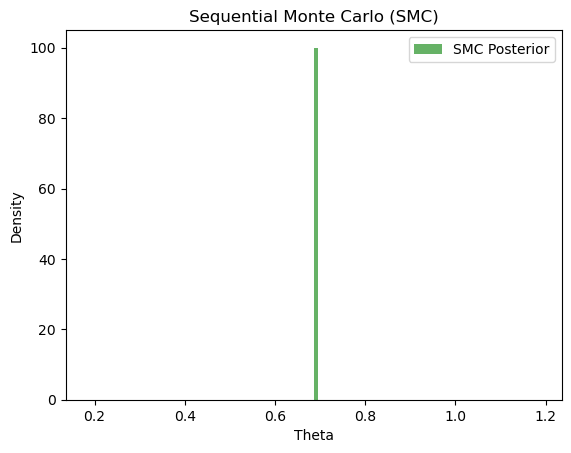

In [5]:
# Plot the results
plt.hist((posterior_samples_gpu["w"]), bins=100, density=True, alpha=0.6, color='g', label='SMC Posterior')
x = np.linspace(-3, 3, 1000)
plt.title("Sequential Monte Carlo (SMC)")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

In [56]:
posterior_samples_gpu[posterior_samples_gpu["weights"] == np.max(posterior_samples_gpu["weights"])]

,mu1,sigma1,mu2,sigma2,w,weights
8062,5.454057,1.695427,0.001439,1.021649,0.328349,0.000594


In [48]:
posterior_samples_gpu[1]

array([0.00021283, 0.00014255, 0.00024999, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [16]:
np.random.uniform(-0.1, 0.1, num_particles)

array([-0.04067024,  0.03206818,  0.09455619, ...,  0.03114635,
        0.04043724,  0.08832488])